# DonorsChoose : Application Screening

## Description
<p> Source : https://www.kaggle.com/c/donorschoose-application-screening </p>
<p> Download train.zip and resources.zip from Kaggle.</p> 

### Problem statement :
<p> Predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved or not </p>

## Performance Metric

Source: https://www.kaggle.com/c/donorschoose-application-screening/overview/evaluation

Metric(s):

    Area Under Curve (AOC)
    Confusion Matrix

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import roc_curve, confusion_matrix

from nltk.corpus import stopwords
from tqdm import tqdm

import nltk
import string
import re
import os
import pickle
from collections import Counter

## 1.1 Reading Data

In [0]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [3]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [4]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


# 1.2 Data Analysis

Number of projects thar are approved for funding  92706 , ( 84.85830404217927 %)
Number of projects thar are not approved for funding  16542 , ( 15.141695957820739 %)


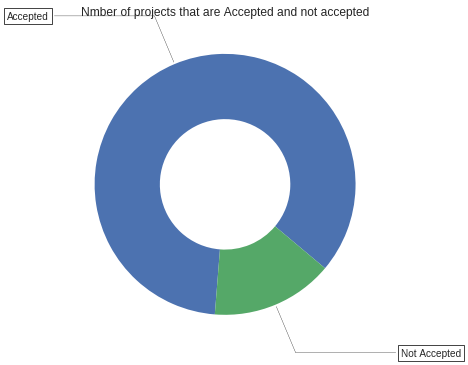

In [5]:
#https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html#sphx-glr-gallery-pie-and-polar-charts-pie-and-donut-labels-py

y_value_counts = project_data['project_is_approved'].value_counts()
print("Number of projects thar are approved for funding ", y_value_counts[1], ", (", (y_value_counts[1]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")
print("Number of projects thar are not approved for funding ", y_value_counts[0], ", (", (y_value_counts[0]/(y_value_counts[1]+y_value_counts[0]))*100,"%)")

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
recipe = ["Accepted", "Not Accepted"]

data = [y_value_counts[1], y_value_counts[0]]

wedges, texts = ax.pie(data, wedgeprops=dict(width=0.5), startangle=-40)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(xycoords='data', textcoords='data', arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(recipe[i], xy=(x, y), xytext=(1.35*np.sign(x), 1.4*y),
                 horizontalalignment=horizontalalignment, **kw)

ax.set_title("Nmber of projects that are Accepted and not accepted")

plt.show()

### 1.2.1 Univariate Analysis: School State

In [ ]:
#Pandas dataframe groupby count, mean: https://stackoverflow.com/a/19385591/4084039

temp = pd.DataFrame(project_data.groupby("school_state")["project_is_approved"].apply(np.mean)).reset_index()
#if you have data which contain only 0 and 1, then the mean = percentage
temp.columns = ['state_code', 'num_proposals']

In [7]:
temp.sort_values(by=['num_proposals'], inplace=True)
print("States with lowest % approvals")
print(temp.head(5))
print('='*50)
print("States with highest % approvals")
print(temp.tail(5))

States with lowest % approvals
   state_code  num_proposals
46         VT       0.800000
7          DC       0.802326
43         TX       0.813142
26         MT       0.816327
18         LA       0.831245
States with highest % approvals
   state_code  num_proposals
30         NH       0.873563
35         OH       0.875152
47         WA       0.876178
28         ND       0.888112
8          DE       0.897959


In [0]:
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2='project_is_approved', col3='total'):
    ind = np.arange(data.shape[0])
    
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)

    plt.ylabel('Projects')
    plt.title('Number of projects aproved vs rejected')
    plt.xticks(ind, list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('total', 'accepted'))
    plt.show()

In [0]:
def univariate_barplots(data, col1, col2='project_is_approved', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    temp = pd.DataFrame(project_data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    temp['total'] = pd.DataFrame(project_data.groupby(col1)[col2].agg({'total':'count'})).reset_index()['total']
    temp['Avg'] = pd.DataFrame(project_data.groupby(col1)[col2].agg({'Avg':'mean'})).reset_index()['Avg']
    
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    
    if top:
        temp = temp[0:top]
    
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    print(temp.head(5))
    print("="*50)
    print(temp.tail(5))

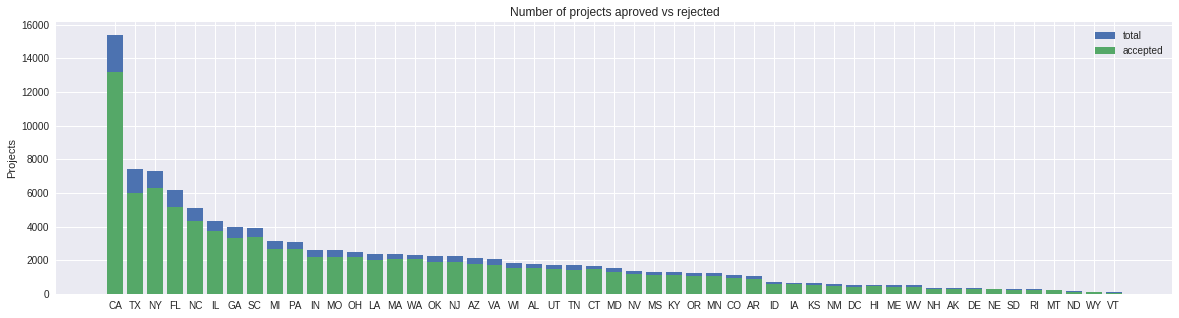

   school_state  project_is_approved  total       Avg
4            CA                13205  15388  0.858136
43           TX                 6014   7396  0.813142
34           NY                 6291   7318  0.859661
9            FL                 5144   6185  0.831690
27           NC                 4353   5091  0.855038
   school_state  project_is_approved  total       Avg
39           RI                  243    285  0.852632
26           MT                  200    245  0.816327
28           ND                  127    143  0.888112
50           WY                   82     98  0.836735
46           VT                   64     80  0.800000


In [10]:
univariate_barplots(project_data, 'school_state', 'project_is_approved', False)

__SUMMARY: Every state has greater than 80% success rate in approval__

### 1.2.2 Univariate Analysis: teacher_prefix

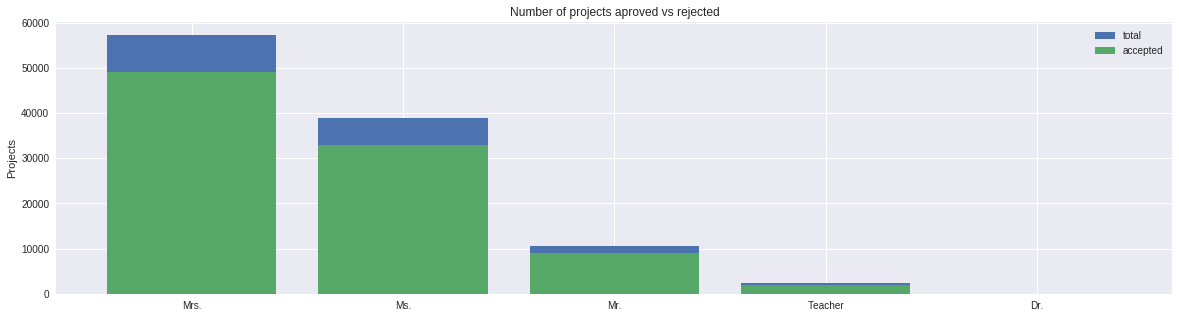

  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308
  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308


In [11]:
univariate_barplots(project_data, 'teacher_prefix', 'project_is_approved' , top=False)

### Observations 

1. About 97.82%((57269 + 38955 + 10648)/109428) of projects are submitted by Mrs. Ms and Mr. prefixes combined.
2. 52.42% of projects have Mrs. as prefix (57269/109248), while the Dr. prefix has only 0.01% (13/109248)
3. From the 5 prefixes, Mrs., Ms., Mr. have more than 84% acceptance rate.
4. Mrs. has the highest acceptance rate of 85.55% and Dr. has the lowest rate of 69.23%
5. The sum of total column (57269 + 38955 + 10648 + 2360 + 13) is 109245 which is 3 less than 109248. This means there are 3 projects who do not have Teacher prefix. Their value is NaN
6. There is huge variablity in number of projects from each prefix and also their approval rate has variablity which can give some help in classification.

### 1.2.3 Univariate Analysis: project_grade_category

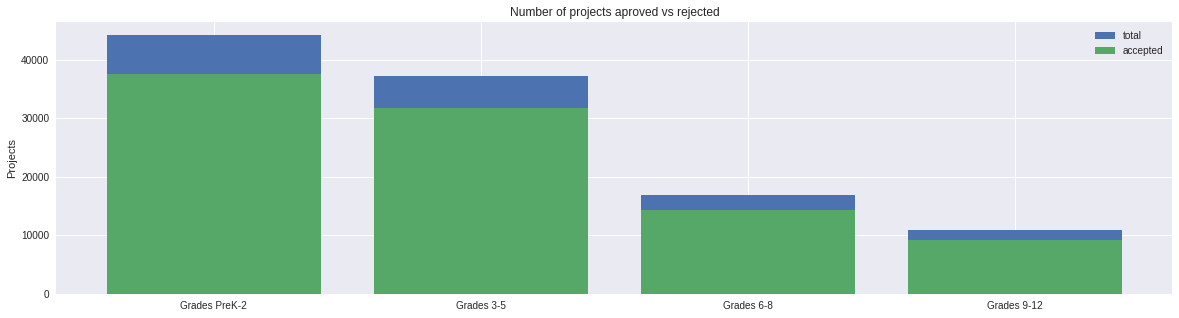

  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636
  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636


In [12]:
univariate_barplots(project_data, 'project_grade_category', 'project_is_approved', top=False)

### Observations

1. Every grade has more than 83% acceptance rate.
2. There are more project submissions in PreK-2 grade, and the value decreases as the grade increases.
3. 40.48% of projects are from PreK-2 Grade.
4. Grade 3-5 has highest approval rate of 85.43% while Grade 9-12 has lowest rate of 83.76.
5. Though there is a variablity in number of projects from each grade, the acceptance rate is almost same for each grade.

### 1.2.4 Univariate Analysis: project_subject_categories

In [0]:
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

catogories = list(project_data['project_subject_categories'].values)
cat_list = []
for i in catogories:
    temp = ""
    for j in i.split(','): 
        if 'The' in j.split(): 
            j=j.replace('The','') 
        j = j.replace(' ','') 
        temp+=j.strip()+" " 
        temp = temp.replace('&','_')
    cat_list.append(temp.strip())

In [14]:
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports


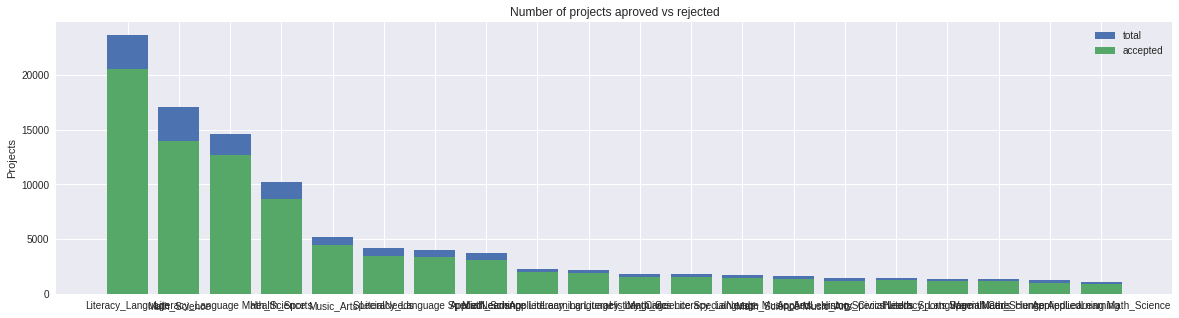

                  clean_categories  project_is_approved  total       Avg
24               Literacy_Language                20520  23655  0.867470
32                    Math_Science                13991  17072  0.819529
28  Literacy_Language Math_Science                12725  14636  0.869432
8                    Health_Sports                 8640  10177  0.848973
40                      Music_Arts                 4429   5180  0.855019
                    clean_categories  project_is_approved  total       Avg
19  History_Civics Literacy_Language                 1271   1421  0.894441
14        Health_Sports SpecialNeeds                 1215   1391  0.873472
50                Warmth Care_Hunger                 1212   1309  0.925898
33      Math_Science AppliedLearning                 1019   1220  0.835246
4       AppliedLearning Math_Science                  855   1052  0.812738


In [15]:
univariate_barplots(project_data, 'clean_categories', 'project_is_approved', top=20)

### Observations

1. The acceptance rate of each subject category is more than 80%
2. Literacy_Language has the highest number of project submissions (23655/109248) which is 21.65%
3. Literacy_Language and Math_Science co-occur together 13.39% of time(14626/109248) which is highest for co-occur categories.
4. Also the acceptance rate of Literacy_Language and Math_Science is more than that of Math_Science.
5. Warmth and Care_Hunger have an acceptance rate of 92.58%
6. There is variablity in both project submissions and acceptance rate of clean_categories.
7. The data also suggest that Technical categories seem to have a lower acceptance rate than Non-Technical categories.

In [0]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

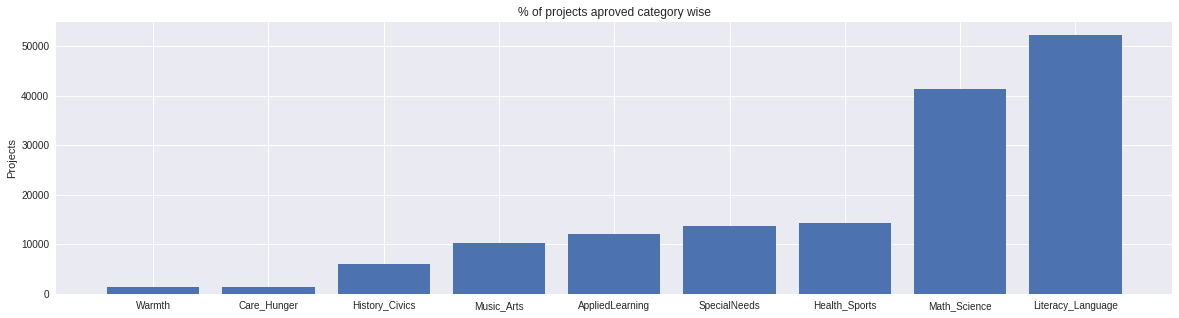

In [17]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))

ind = np.arange(len(sorted_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved category wise')
plt.xticks(ind, list(sorted_cat_dict.keys()))
plt.show()

In [18]:
for i, j in sorted_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Warmth               :      1388
Care_Hunger          :      1388
History_Civics       :      5914
Music_Arts           :     10293
AppliedLearning      :     12135
SpecialNeeds         :     13642
Health_Sports        :     14223
Math_Science         :     41421
Literacy_Language    :     52239


### Observations

1. Literacy_Language category has the highest number of project submissions and Warmth, Care_Hunger have lowest.
2. There is a good variability in the number of project submissions from each category.

### 1.2.5 Univariate Analysis: project_subject_subcategories

In [0]:
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_catogories = list(project_data['project_subject_subcategories'].values)

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    for j in i.split(','):
        if 'The' in j.split():
            j=j.replace('The','')
        j = j.replace(' ','')
        temp +=j.strip()+" "
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [20]:
project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports,Civics_Government TeamSports


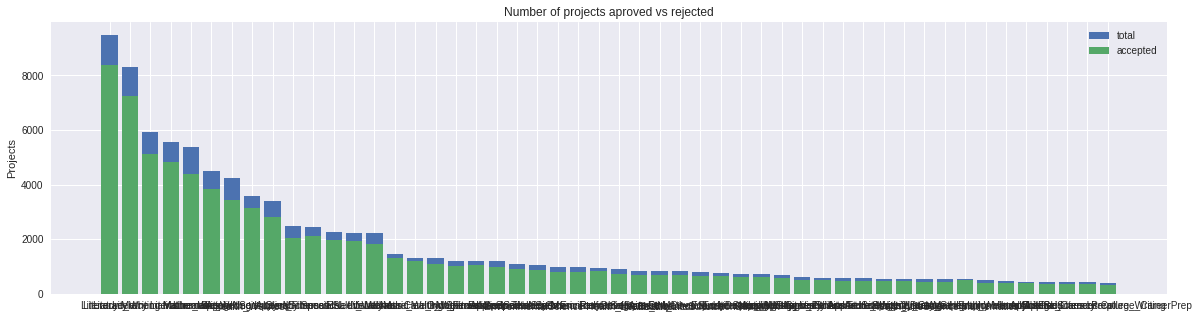

                clean_subcategories  project_is_approved  total       Avg
317                        Literacy                 8371   9486  0.882458
319            Literacy Mathematics                 7260   8325  0.872072
331  Literature_Writing Mathematics                 5140   5923  0.867803
318     Literacy Literature_Writing                 4823   5571  0.865733
342                     Mathematics                 4385   5379  0.815207
                    clean_subcategories  project_is_approved  total       Avg
196       EnvironmentalScience Literacy                  389    444  0.876126
127                                 ESL                  349    421  0.828979
79                   College_CareerPrep                  343    421  0.814727
17   AppliedSciences Literature_Writing                  361    420  0.859524
3    AppliedSciences College_CareerPrep                  330    405  0.814815


In [21]:
univariate_barplots(project_data, 'clean_subcategories', 'project_is_approved', top=50)

### Observations

1. The project subcategories also have an acceptance rate of more than 80%
2. Literacy subcategory has the highest number of project submissions (9486/109248) which is 8.68%
3. Literacy and Mathematics co-occur together 7.62% of time(8325/109248).
4. There is variablity in both project submissions and acceptance rate of clean_categories.

In [0]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())

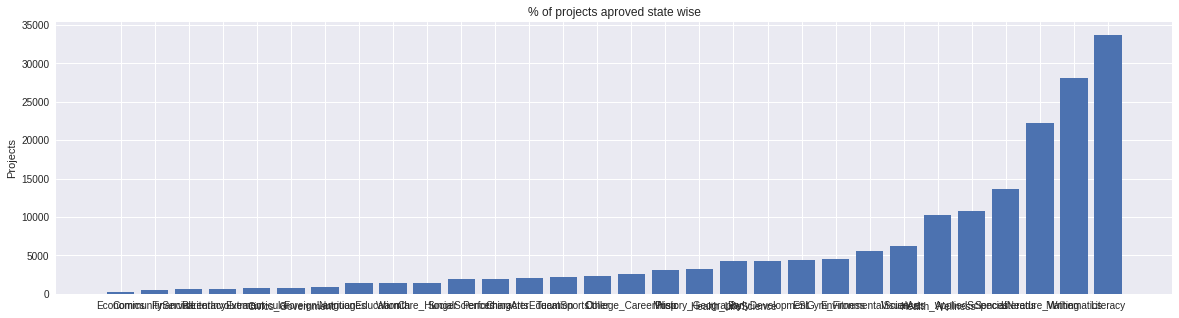

In [23]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))

ind = np.arange(len(sorted_sub_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_sub_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved state wise')
plt.xticks(ind, list(sorted_sub_cat_dict.keys()))
plt.show()

In [24]:
for i, j in sorted_sub_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Economics            :       269
CommunityService     :       441
FinancialLiteracy    :       568
ParentInvolvement    :       677
Extracurricular      :       810
Civics_Government    :       815
ForeignLanguages     :       890
NutritionEducation   :      1355
Warmth               :      1388
Care_Hunger          :      1388
SocialSciences       :      1920
PerformingArts       :      1961
CharacterEducation   :      2065
TeamSports           :      2192
Other                :      2372
College_CareerPrep   :      2568
Music                :      3145
History_Geography    :      3171
Health_LifeScience   :      4235
EarlyDevelopment     :      4254
ESL                  :      4367
Gym_Fitness          :      4509
EnvironmentalScience :      5591
VisualArts           :      6278
Health_Wellness      :     10234
AppliedSciences      :     10816
SpecialNeeds         :     13642
Literature_Writing   :     22179
Mathematics          :     28074
Literacy             :     33700


### Observations 

1. Literacy subcategory has the highest number of project submissions and Economics has lowest.
2. There is a good variability in the number of project submissions from each subcategory.

### 1.2.6 Univariate Analysis: Text features (Title)

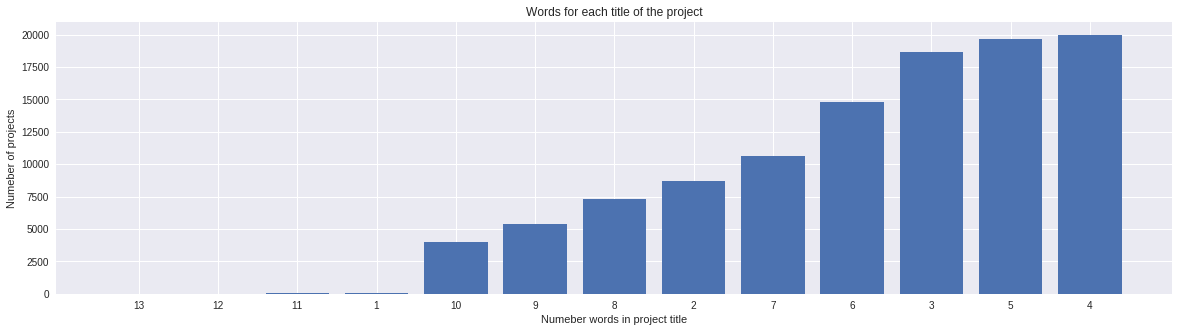

In [25]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = project_data['project_title'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))

ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Numeber of projects')
plt.xlabel('Numeber words in project title')
plt.title('Words for each title of the project')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

### Observations

1. Most of the projects have 3,4 and 5 words in their project title
2. Very few projects have 1, 11, 12 and 13 word title too.

In [0]:
approved_title_word_count = project_data[project_data['project_is_approved']==1]['project_title'].str.split().apply(len)
approved_title_word_count = approved_title_word_count.values

rejected_title_word_count = project_data[project_data['project_is_approved']==0]['project_title'].str.split().apply(len)
rejected_title_word_count = rejected_title_word_count.values

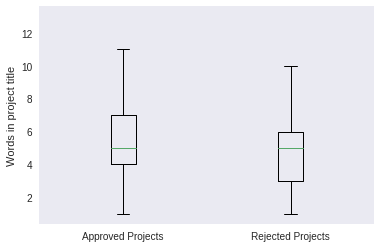

In [27]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_title_word_count, rejected_title_word_count])
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.grid()
plt.show()

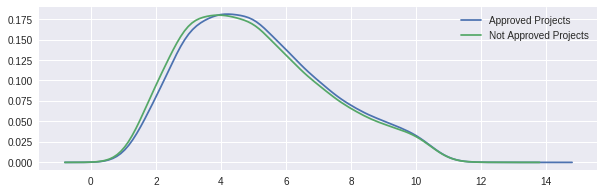

In [28]:
plt.figure(figsize=(10,3))
sns.kdeplot(approved_title_word_count,label="Approved Projects", bw=0.6)
sns.kdeplot(rejected_title_word_count,label="Not Approved Projects", bw=0.6)
plt.legend()
plt.show()

### Observations

1. The median value of both approved and rejected projects with respect to project title is almost same.
2. The distribution of Approved projects is slightly ahead than that of Not Approved prjects, which means the number of words in project title is slightly more for Approved Projects
3. Due to very slight difference this feature cannot help in classification

### 1.2.7 Univariate Analysis: Text features (Project Essay's)

In [0]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [0]:
approved_word_count = project_data[project_data['project_is_approved']==1]['essay'].str.split().apply(len)
approved_word_count = approved_word_count.values

rejected_word_count = project_data[project_data['project_is_approved']==0]['essay'].str.split().apply(len)
rejected_word_count = rejected_word_count.values

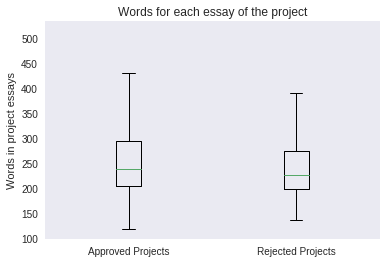

In [31]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_word_count, rejected_word_count])
plt.title('Words for each essay of the project')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project essays')
plt.grid()
plt.show()

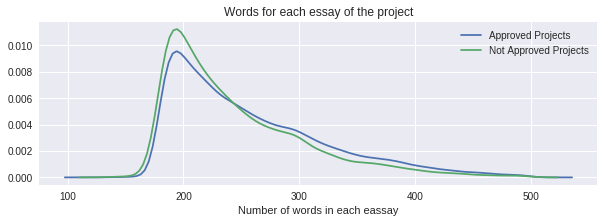

In [32]:
plt.figure(figsize=(10,3))
sns.distplot(approved_word_count, hist=False, label="Approved Projects")
sns.distplot(rejected_word_count, hist=False, label="Not Approved Projects")
plt.title('Words for each essay of the project')
plt.xlabel('Number of words in each eassay')
plt.legend()
plt.show()

### Observations

1. The median value of both approved and rejected projects with respect to project title is almost same.
2. The distribution of Approved projects is slightly ahead than that of Not Approved prjects, which means the number of words in project title is slightly more for Approved Projects
3. Due to very slight difference this feature cannot help in classification

### 1.2.8 Univariate Analysis: Cost per project

In [33]:
# we get the cost of the project using resource.csv file
resource_data.head(2)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


In [34]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21


In [0]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [0]:
approved_price = project_data[project_data['project_is_approved']==1]['price'].values

rejected_price = project_data[project_data['project_is_approved']==0]['price'].values

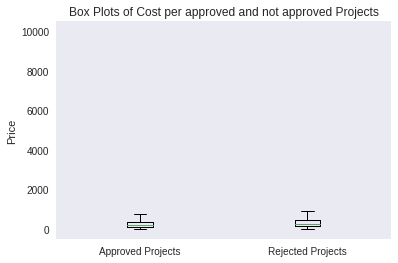

In [37]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_price, rejected_price])
plt.title('Box Plots of Cost per approved and not approved Projects')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Price')
plt.grid()
plt.show()

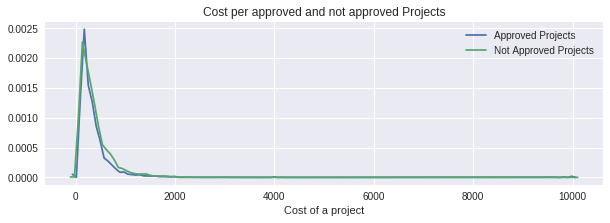

In [38]:
plt.figure(figsize=(10,3))
sns.distplot(approved_price, hist=False, label="Approved Projects")
sns.distplot(rejected_price, hist=False, label="Not Approved Projects")
plt.title('Cost per approved and not approved Projects')
plt.xlabel('Cost of a project')
plt.legend()
plt.show()

### Observations

1. The plot shows that Not approved projects tend to cost slightly higher than Approved projects.
2. Not much can be observed from the Box plots and PDF

In [39]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()
x.field_names = ["Percentile", "Approved Projects", "Not Approved Projects"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(approved_price,i), 3), np.round(np.percentile(rejected_price,i), 3)])
print(x)

+------------+-------------------+-----------------------+
| Percentile | Approved Projects | Not Approved Projects |
+------------+-------------------+-----------------------+
|     0      |        0.66       |          1.97         |
|     5      |       13.59       |          41.9         |
|     10     |       33.88       |         73.67         |
|     15     |        58.0       |         99.109        |
|     20     |       77.38       |         118.56        |
|     25     |       99.95       |        140.892        |
|     30     |       116.68      |         162.23        |
|     35     |      137.232      |        184.014        |
|     40     |       157.0       |        208.632        |
|     45     |      178.265      |        235.106        |
|     50     |       198.99      |        263.145        |
|     55     |       223.99      |         292.61        |
|     60     |       255.63      |        325.144        |
|     65     |      285.412      |         362.39       

### Observations

1. At any percentile the Approved projects has lower price compared to Not Approved projects.

<h3><font color='red'>1.2.9 Univariate Analysis: teacher_number_of_previously_posted_projects</font></h3>

Please do this on your own based on the data analysis that was done in the above cells

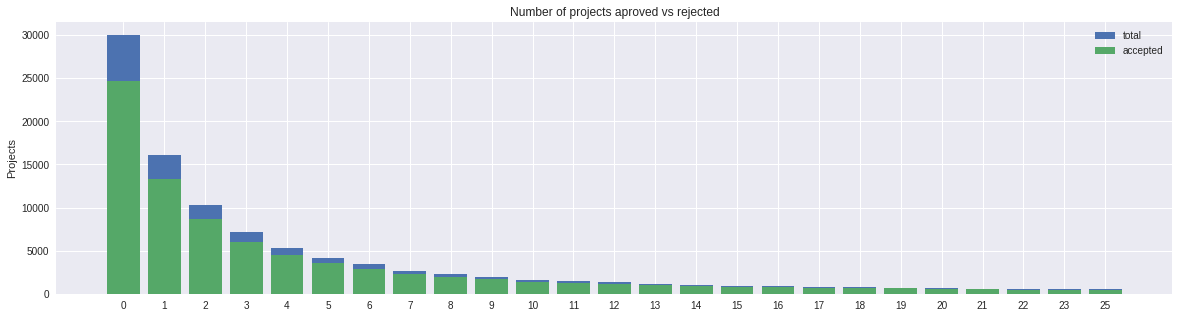

   teacher_number_of_previously_posted_projects  project_is_approved  total  \
0                                             0                24652  30014   
1                                             1                13329  16058   
2                                             2                 8705  10350   
3                                             3                 5997   7110   
4                                             4                 4452   5266   

        Avg  
0  0.821350  
1  0.830054  
2  0.841063  
3  0.843460  
4  0.845423  
    teacher_number_of_previously_posted_projects  project_is_approved  total  \
20                                            20                  578    661   
21                                            21                  519    584   
22                                            22                  495    548   
23                                            23                  479    536   
25                                       

In [40]:
univariate_barplots(project_data, 'teacher_number_of_previously_posted_projects', 'project_is_approved', top = 25)

### Observations

1. The acceptance rate for every value is more than 80%
2. As value of teacher_number_of_previously_posted_projects increases the acceptance rate increases.
3. There are almost 27.47% (30014/109428) of projects which are posted by teachers who have posted 0 times previously.
4. There are 509 projects which have been posted by teachers who have posted 25 times previously
5. There is variablity in both project submissions and acceptance rate of teacher_number_of_previously_posted_projects

In [0]:
approved_when_previously_posted = project_data[project_data['project_is_approved']==1]['teacher_number_of_previously_posted_projects']
rejected_when_previously_posted = project_data[project_data['project_is_approved']==0]['teacher_number_of_previously_posted_projects']

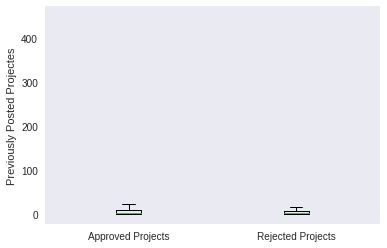

In [42]:
plt.boxplot([approved_when_previously_posted, rejected_when_previously_posted])
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Previously Posted Projectes')
plt.grid()
plt.show()

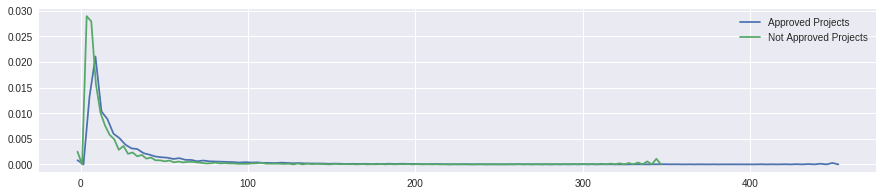

In [43]:
plt.figure(figsize=(15,3))
sns.kdeplot(approved_when_previously_posted,label="Approved Projects", bw=0.6)
sns.kdeplot(rejected_when_previously_posted,label="Not Approved Projects", bw=0.6)
plt.legend()
plt.show()

In [44]:
x = PrettyTable()
x.field_names = ["Percentile", "Approved Projects", "Not Approved Projects"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(approved_when_previously_posted, i), 3), np.round(np.percentile(rejected_when_previously_posted,i), 3)])
print(x)

+------------+-------------------+-----------------------+
| Percentile | Approved Projects | Not Approved Projects |
+------------+-------------------+-----------------------+
|     0      |        0.0        |          0.0          |
|     5      |        0.0        |          0.0          |
|     10     |        0.0        |          0.0          |
|     15     |        0.0        |          0.0          |
|     20     |        0.0        |          0.0          |
|     25     |        0.0        |          0.0          |
|     30     |        1.0        |          0.0          |
|     35     |        1.0        |          1.0          |
|     40     |        1.0        |          1.0          |
|     45     |        2.0        |          1.0          |
|     50     |        2.0        |          2.0          |
|     55     |        3.0        |          2.0          |
|     60     |        4.0        |          3.0          |
|     65     |        5.0        |          3.0         

### Observations

1. We can say that as the Number of projects posted by a teacher increases its approval rate increases.

In [0]:
project_resource_summary = list(project_data['project_resource_summary'].values)
digit_in_summary = np.zeros(len(project_resource_summary))

#check if string contains a number python: https://stackoverflow.com/questions/19859282/check-if-a-string-contains-a-number
def hasNumbers(inputString):
     return any(char.isdigit() for char in inputString)

for i in range(len(project_resource_summary)):
  if hasNumbers(project_resource_summary[i]):
    digit_in_summary[i] = 1

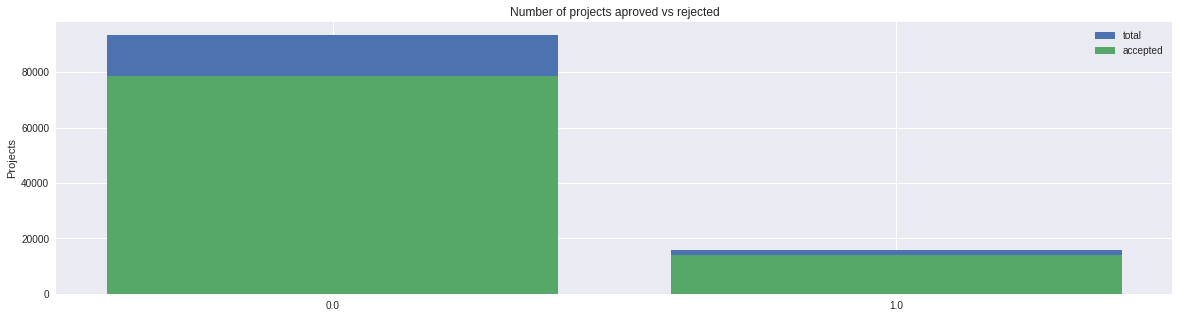

   digit_in_summary  project_is_approved  total       Avg
0               0.0                78616  93492  0.840885
1               1.0                14090  15756  0.894263
   digit_in_summary  project_is_approved  total       Avg
0               0.0                78616  93492  0.840885
1               1.0                14090  15756  0.894263


In [46]:
temp = project_data
temp['digit_in_summary'] = digit_in_summary
univariate_barplots(temp, 'digit_in_summary', 'project_is_approved', top = False)

### Observations

1. There are 85.57% of projects who do not have digit in their summary and 14.43 which have a digit in summary.
2. The acceptance rate for having a digit is slightly more than not having a digit
3. I don't think digit_in_summary can help in classification

## 1.3 Text preprocessing

### 1.3.1 Essay Text

In [47]:
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,...,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,quantity,digit_in_summary
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",...,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy,My students are English learners that are work...,154.6,23,0.0
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,...,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports,Civics_Government TeamSports,Our students arrive to our school eager to lea...,299.0,1,0.0


In [48]:
# printing some random essays.
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[1000])
print("="*50)
print(project_data['essay'].values[20000])
print("="*50)
print(project_data['essay'].values[99999])
print("="*50)


My students are English learners that are working on English as their second or third languages. We are a melting pot of refugees, immigrants, and native-born Americans bringing the gift of language to our school. \r\n\r\n We have over 24 languages represented in our English Learner program with students at every level of mastery.  We also have over 40 countries represented with the families within our school.  Each student brings a wealth of knowledge and experiences to us that open our eyes to new cultures, beliefs, and respect.\"The limits of your language are the limits of your world.\"-Ludwig Wittgenstein  Our English learner's have a strong support system at home that begs for more resources.  Many times our parents are learning to read and speak English along side of their children.  Sometimes this creates barriers for parents to be able to help their child learn phonetics, letter recognition, and other reading skills.\r\n\r\nBy providing these dvd's and players, students are ab

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [50]:
sent = decontracted(project_data['essay'].values[20000])
print(sent)
print("="*50)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations. \r\n\r\nThe materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills. \r\nThey also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing

In [51]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays, cognitive delays, gross/fine motor delays, to autism. They are eager beavers and always strive to work their hardest working past their limitations.     The materials we have are the ones I seek out for my students. I teach in a Title I school where most of the students receive free or reduced price lunch.  Despite their disabilities and limitations, my students love coming to school and come eager to learn and explore.Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting? This is how my kids feel all the time. The want to be able to move as they learn or so they say.Wobble chairs are the answer and I love then because they develop their core, which enhances gross motor and in Turn fine motor skills.   They also want to learn through games, my kids do not want to sit and do worksheets. They want to learn to count by jumping and playing. Phys

In [52]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

My kindergarten students have varied disabilities ranging from speech and language delays cognitive delays gross fine motor delays to autism They are eager beavers and always strive to work their hardest working past their limitations The materials we have are the ones I seek out for my students I teach in a Title I school where most of the students receive free or reduced price lunch Despite their disabilities and limitations my students love coming to school and come eager to learn and explore Have you ever felt like you had ants in your pants and you needed to groove and move as you were in a meeting This is how my kids feel all the time The want to be able to move as they learn or so they say Wobble chairs are the answer and I love then because they develop their core which enhances gross motor and in Turn fine motor skills They also want to learn through games my kids do not want to sit and do worksheets They want to learn to count by jumping and playing Physical engagement is the

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [54]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|██████████| 109248/109248 [01:08<00:00, 1587.66it/s]


In [55]:
# after preprocesing
preprocessed_essays[20000]

'my kindergarten students varied disabilities ranging speech language delays cognitive delays gross fine motor delays autism they eager beavers always strive work hardest working past limitations the materials ones i seek students i teach title i school students receive free reduced price lunch despite disabilities limitations students love coming school come eager learn explore have ever felt like ants pants needed groove move meeting this kids feel time the want able move learn say wobble chairs answer i love develop core enhances gross motor turn fine motor skills they also want learn games kids not want sit worksheets they want learn count jumping playing physical engagement key success the number toss color shape mats make happen my students forget work fun 6 year old deserves nannan'

In [56]:
# similarly you can preprocess the titles also
preprocessed_titles = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_titles.append(sent.lower().strip())
preprocessed_titles[5438]

100%|██████████| 109248/109248 [00:03<00:00, 32660.85it/s]


'mac imize steam'

## 1. 4 Preparing data for models

In [57]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price', 'quantity',
       'digit_in_summary'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data
       
       - quantity : numerical
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

### 1.4.1 Vectorizing Categorical data

In [58]:
# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['clean_categories'].values)
print(vectorizer.get_feature_names())


categories_one_hot = vectorizer.transform(project_data['clean_categories'].values)
print("Shape of matrix after one hot encodig ",categories_one_hot.shape)

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix after one hot encodig  (109248, 9)


In [59]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['clean_subcategories'].values)
print(vectorizer.get_feature_names())


sub_categories_one_hot = vectorizer.transform(project_data['clean_subcategories'].values)
print("Shape of matrix after one hot encodig ",sub_categories_one_hot.shape)

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix after one hot encodig  (109248, 30)


In [60]:
vectorizer = CountVectorizer(vocabulary=list(project_data['school_state'].drop_duplicates(keep = 'first', inplace = False)), lowercase=False, binary=True)
vectorizer.fit(project_data['school_state'].values)
print(vectorizer.get_feature_names())


school_state_one_hot = vectorizer.transform(project_data['school_state'].values)
print("Shape of matrix after one hot encodig ",school_state_one_hot.shape)

['IN', 'FL', 'AZ', 'KY', 'TX', 'CT', 'GA', 'SC', 'NC', 'CA', 'NY', 'OK', 'MA', 'NV', 'OH', 'PA', 'AL', 'LA', 'VA', 'AR', 'WA', 'WV', 'ID', 'TN', 'MS', 'CO', 'UT', 'IL', 'MI', 'HI', 'IA', 'RI', 'NJ', 'MO', 'DE', 'MN', 'ME', 'WY', 'ND', 'OR', 'AK', 'MD', 'WI', 'SD', 'NE', 'NM', 'DC', 'KS', 'MT', 'NH', 'VT']
Shape of matrix after one hot encodig  (109248, 51)


In [61]:
#3 rows with NaN present. Converting them to string and considering them as teacher prefix. Note : We cannot dorp NaN as this changes dimensions, although we can replace Nan
vectorizer = CountVectorizer(vocabulary=list(project_data['teacher_prefix'].drop_duplicates(keep = 'first', inplace = False)), lowercase=False, binary=True)
vectorizer.fit(map(str,project_data['teacher_prefix'].values))
print(vectorizer.get_feature_names())


teacher_prefix_one_hot = vectorizer.transform(map(str,project_data['teacher_prefix'].values))
print("Shape of matrix after one hot encodig ",teacher_prefix_one_hot.shape)

['Mrs.', 'Mr.', 'Ms.', 'Teacher', nan, 'Dr.']
Shape of matrix after one hot encodig  (109248, 6)


In [62]:
vectorizer = CountVectorizer(vocabulary=list(project_data['project_grade_category'].drop_duplicates(keep = 'first', inplace = False)), lowercase=False, binary=True)
vectorizer.fit(project_data['project_grade_category'].values)
print(vectorizer.get_feature_names())


project_grade_category_one_hot = vectorizer.transform(project_data['project_grade_category'].values)
print("Shape of matrix after one hot encodig ",project_grade_category_one_hot.shape)

['Grades PreK-2', 'Grades 6-8', 'Grades 3-5', 'Grades 9-12']
Shape of matrix after one hot encodig  (109248, 4)


### 1.4.2 Vectorizing Text data

#### 1.4.2.1 Bag of words

In [63]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10)
text_bow = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",text_bow.shape)

Shape of matrix after one hot encodig  (109248, 16623)


In [65]:
vectorizer = CountVectorizer(min_df=10)
titles_bow = vectorizer.fit_transform(preprocessed_titles)
print("Shape of matrix after one hot encodig ",titles_bow.shape)

Shape of matrix after one hot encodig  (109248, 3329)


#### 1.4.2.3 TFIDF vectorizer

In [66]:
vectorizer = TfidfVectorizer(min_df=10)
text_tfidf = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",text_tfidf.shape)

Shape of matrix after one hot encodig  (109248, 16623)


In [67]:
vectorizer = TfidfVectorizer(min_df=10)
titles_tfidf = vectorizer.fit_transform(preprocessed_titles)
print("Shape of matrix after one hot encodig ",titles_tfidf.shape)

Shape of matrix after one hot encodig  (109248, 3329)


#### 1.4.2.5 Using Pretrained Models: Avg W2V

In [68]:
'''
# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039
def loadGloveModel(gloveFile):
    print ("Loading Glove Model")
    f = open(gloveFile,'r', encoding="utf8")
    model = {}
    for line in tqdm(f):
        splitLine = line.split()
        word = splitLine[0]
        embedding = np.array([float(val) for val in splitLine[1:]])
        model[word] = embedding
    print ("Done.",len(model)," words loaded!")
    return model
model = loadGloveModel('glove.42B.300d.txt')


words = []
for i in preproced_texts:
    words.extend(i.split(' '))

for i in preproced_titles:
    words.extend(i.split(' '))
print("all the words in the coupus", len(words))
words = set(words)
print("the unique words in the coupus", len(words))

inter_words = set(model.keys()).intersection(words)
print("The number of words that are present in both glove vectors and our coupus", \
      len(inter_words),"(",np.round(len(inter_words)/len(words)*100,3),"%)")

words_courpus = {}
words_glove = set(model.keys())
for i in words:
    if i in words_glove:
        words_courpus[i] = model[i]
print("word 2 vec length", len(words_courpus))


# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/

import pickle
with open('glove_vectors', 'wb') as f:
    pickle.dump(words_courpus, f)


'''

'\n# Reading glove vectors in python: https://stackoverflow.com/a/38230349/4084039\ndef loadGloveModel(gloveFile):\n    print ("Loading Glove Model")\n    f = open(gloveFile,\'r\', encoding="utf8")\n    model = {}\n    for line in tqdm(f):\n        splitLine = line.split()\n        word = splitLine[0]\n        embedding = np.array([float(val) for val in splitLine[1:]])\n        model[word] = embedding\n    print ("Done.",len(model)," words loaded!")\n    return model\nmodel = loadGloveModel(\'glove.42B.300d.txt\')\n\n# ============================\nOutput:\n    \nLoading Glove Model\n1917495it [06:32, 4879.69it/s]\nDone. 1917495  words loaded!\n\n# ============================\n\nwords = []\nfor i in preproced_texts:\n    words.extend(i.split(\' \'))\n\nfor i in preproced_titles:\n    words.extend(i.split(\' \'))\nprint("all the words in the coupus", len(words))\nwords = set(words)\nprint("the unique words in the coupus", len(words))\n\ninter_words = set(model.keys()).intersection(word

In [0]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [70]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors.append(vector)

print(len(avg_w2v_vectors))
print(len(avg_w2v_vectors[0]))

100%|██████████| 109248/109248 [00:38<00:00, 2873.92it/s]

109248
300


In [71]:
avg_w2v_vectors_titles = []; 
for sentence in tqdm(preprocessed_titles): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_titles.append(vector)

print(len(avg_w2v_vectors_titles))
print(len(avg_w2v_vectors_titles[0]))

100%|██████████| 109248/109248 [00:01<00:00, 57635.72it/s]

109248
300


#### 1.4.2.7 Using Pretrained Models: TFIDF weighted W2V

In [0]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [73]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors = [];
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word]
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))

100%|██████████| 109248/109248 [03:54<00:00, 465.68it/s]

109248
300


In [0]:
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_titles)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [75]:
tfidf_w2v_vectors_titles = [];
for sentence in tqdm(preprocessed_titles): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word]
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split()))
            vector += (vec * tf_idf)
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_titles.append(vector)

print(len(tfidf_w2v_vectors_titles))
print(len(tfidf_w2v_vectors_titles[0]))

100%|██████████| 109248/109248 [00:05<00:00, 21832.31it/s]

109248
300


### 1.4.3 Vectorizing Numerical features

In [0]:
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

price_scalar = StandardScaler()
price_scalar.fit(project_data['price'].values.reshape(-1,1))
price_standardized = price_scalar.transform(project_data['price'].values.reshape(-1, 1))

In [77]:
price_standardized

array([[-0.3905327 ],
       [ 0.00239637],
       [ 0.59519138],
       ...,
       [-0.15825829],
       [-0.61243967],
       [-0.51216657]])

In [0]:
teacher_number_of_previously_posted_projects_scalar = StandardScaler()
teacher_number_of_previously_posted_projects_scalar.fit(project_data['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
teacher_number_of_previously_posted_projects_standardized = price_scalar.transform(project_data['price'].values.reshape(-1, 1))

In [79]:
teacher_number_of_previously_posted_projects_standardized

array([[-0.3905327 ],
       [ 0.00239637],
       [ 0.59519138],
       ...,
       [-0.15825829],
       [-0.61243967],
       [-0.51216657]])

### 1.4.4 Merging all the above features

In [0]:
print(categories_one_hot.shape)
print(sub_categories_one_hot.shape)
print(text_bow.shape)
print(price_standardized.shape)

(109248, 9)
(109248, 30)
(109248, 16623)
(109248, 1)


In [0]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
X = hstack((categories_one_hot, sub_categories_one_hot, text_bow, price_standardized))
X.shape

(109248, 16663)

## TSNE Visualization

<h2> 2.1 TSNE with `BOW` encoding of `project_title` feature </h2>

In [0]:
from scipy.sparse import hstack
X = hstack((school_state_one_hot,categories_one_hot, sub_categories_one_hot, teacher_prefix_one_hot, titles_bow, price_standardized, teacher_number_of_previously_posted_projects_standardized)) 
X = X.toarray()

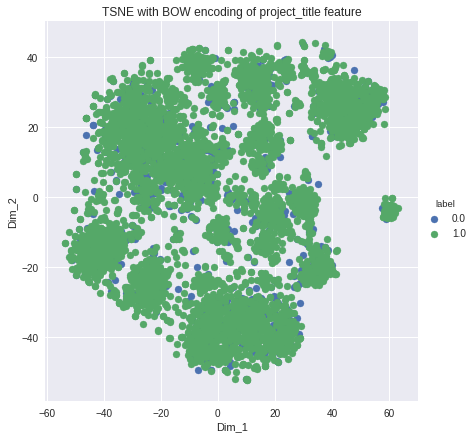

In [83]:
#taking only 5k data points using train and test split
from sklearn.manifold import TSNE
from sklearn import model_selection
from sklearn.model_selection import train_test_split

Y = project_data[:]['project_is_approved']
x, xx, y, yy = model_selection.train_test_split(X, Y, test_size=0.954, random_state=0)     #splitting to get 5k data points

model = TSNE(n_components=2, random_state=0)

tsne_data = model.fit_transform(x)

tsne_data = np.vstack((tsne_data.T, y)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE with BOW encoding of project_title feature")
plt.show()

<h2> 2.2 TSNE with `TFIDF` encoding of `project_title` feature </h2>

In [0]:
X = hstack((school_state_one_hot,categories_one_hot, sub_categories_one_hot, teacher_prefix_one_hot, titles_tfidf, price_standardized, teacher_number_of_previously_posted_projects_standardized))
X = X.toarray()

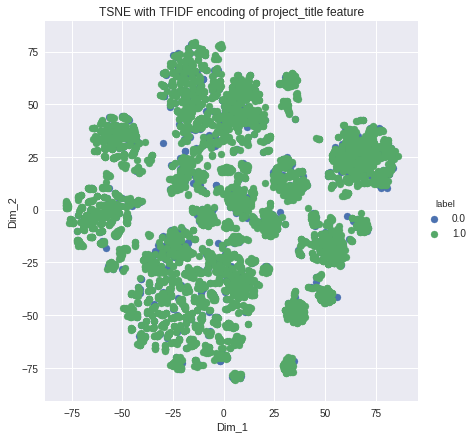

In [85]:
#taking only 5k data points using train and test split
from sklearn.manifold import TSNE
from sklearn import model_selection
from sklearn.model_selection import train_test_split

Y = project_data[:]['project_is_approved']
x, xx, y, yy = model_selection.train_test_split(X, Y, test_size=0.954, random_state=0)     #splitting to get 5k data points

model = TSNE(n_components=2, random_state=0)

tsne_data = model.fit_transform(x)

tsne_data = np.vstack((tsne_data.T, y)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE with TFIDF encoding of project_title feature")
plt.show()

<h2> 2.3 TSNE with `AVG W2V` encoding of `project_title` feature </h2>

In [0]:
X = hstack((school_state_one_hot,categories_one_hot, sub_categories_one_hot, teacher_prefix_one_hot, avg_w2v_vectors_titles, price_standardized, teacher_number_of_previously_posted_projects_standardized))
X = X.toarray()

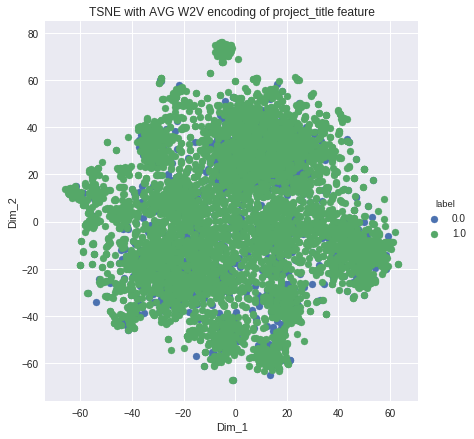

In [87]:
#taking only 5k data points using train and test split
from sklearn.manifold import TSNE
from sklearn import model_selection
from sklearn.model_selection import train_test_split

Y = project_data[:]['project_is_approved']
x, xx, y, yy = model_selection.train_test_split(X, Y, test_size=0.954, random_state=0)     #splitting to get 5k data points

model = TSNE(n_components=2, random_state=0)

tsne_data = model.fit_transform(x)

tsne_data = np.vstack((tsne_data.T, y)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE with AVG W2V encoding of project_title feature")
plt.show()

<h2> 2.4 TSNE with `TFIDF Weighted W2V` encoding of `project_title` feature </h2>

In [0]:
X = hstack((school_state_one_hot,categories_one_hot, sub_categories_one_hot, teacher_prefix_one_hot, tfidf_w2v_vectors_titles, price_standardized, teacher_number_of_previously_posted_projects_standardized))
X = X.toarray()

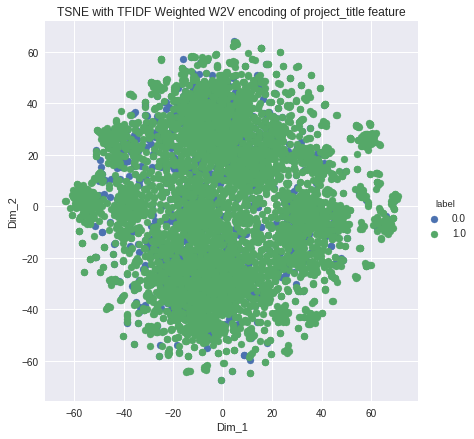

In [89]:
#taking only 5k data points using train and test split
from sklearn.manifold import TSNE
from sklearn import model_selection
from sklearn.model_selection import train_test_split

Y = project_data[:]['project_is_approved']
x, xx, y, yy = model_selection.train_test_split(X, Y, test_size=0.954, random_state=0)     #splitting to get 5k data points

model = TSNE(n_components=2, random_state=0)

tsne_data = model.fit_transform(x)

tsne_data = np.vstack((tsne_data.T, y)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE with TFIDF Weighted W2V encoding of project_title feature")
plt.show()

## 2.5 TSNE with all features 

In [0]:
X = hstack((school_state_one_hot,categories_one_hot, sub_categories_one_hot, teacher_prefix_one_hot, titles_bow, titles_tfidf, avg_w2v_vectors_titles, tfidf_w2v_vectors_titles, price_standardized, teacher_number_of_previously_posted_projects_standardized))
X = X.toarray()

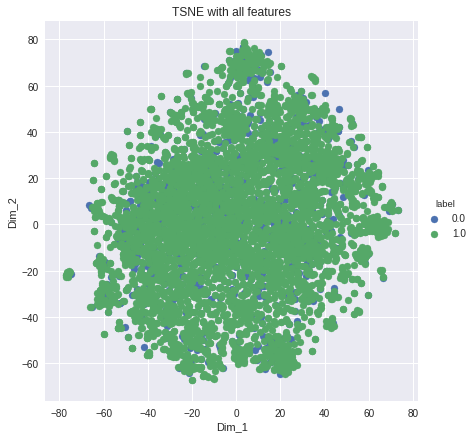

In [84]:
from sklearn.manifold import TSNE
from sklearn import model_selection
from sklearn.model_selection import train_test_split

Y = project_data[:]['project_is_approved']
x = X[:5000]                                          #using train_test_split causes memory issues hence using first 5k data points
y = Y[:5000]                                          

model = TSNE(n_components=2, random_state=0)

tsne_data = model.fit_transform(x)

tsne_data = np.vstack((tsne_data.T, y)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dim_1", "Dim_2", "label"))

sns.FacetGrid(tsne_df, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.title("TSNE with all features")
plt.show()

<h2> 2.5 Summary </h2>

1. The TSNE plots of all features do not help much in visualization.
2. As the dataset is highly imbalanced, there is a huge spread of approved projects over non approved projects hence visualizing is difficult.
3. BOW and TFIDF plots have some little clusters but TSNE with AVG W2V, TFIDF Weighted W2V and all featuers do not have a small cluster but one big cluster indicating that points in these space are closely grouped.